# Exploration 7. 인물사진을 만들어 보자

본 과제는 딥러닝 기술울 이용하여 사진에 핸드폰의 인물 사진 모드에 해당하는 셸로우 포커스(shallow focus)를 적용하는 작업이다. 

## 루브릭 평가 기준
1. 인물모드 사진을 성공적으로 제작하였다.
   아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
   인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
   추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

* * *

## 하나의 카메라로 셸로우 포커스(shallow focus) 만들기
1. 배경이 있는 사진을 촬영(배경과 사람의 거리가 약간 멀리 있는 것이 좋음)
2. 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리
3. 블러링(blurring) 기술로 배경을 흐리게 함
4. 피사체를 배경의 원래 위치에 합성

## 시맨틱 세그멘테이션(Semantic segmentation)
* 이미지 내에 있는 물체들을 의미 있는 단위로 분할(이미지의 각 픽셀이 어느 클래스에 속하는지 예측)
* 이미지 내 모든 픽셀에 대해서 예측을 진행하기 때문에 dense prediction이라고 부르기도 함
* 이미지 내에 존재하는 서로 다른 종류의 물체들을 깔끔하게 분할
* segmentation map
  * semantic segmentation을 어떤 이미지에 시행하면 그림과 같이 각 픽셀이 어느 클래스에 속하는지 파악 가능
  <img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJxoTd%2FbtqvGCuwDOc%2FJS8wb7Vvn4fJH1wTHFT9sk%2Fimg.png">
  * semantic segmentation 알고리즘의 입력값은 컬러 이미지 또는 흑백 이미지고, 출력값은 각 픽셀의 예측된 클래스를 나타내는 segmentation map으로, segmentation map을 얻는 것이 semantic segmentation의 실질적 목적
* 참고 링크 : [semantic segmentation의 목적과 대표 알고리즘 FCN의 원리](https://bskyvision.com/491)

* * *

## 모듈 및 이미지 로드
* <span style='background-color: #f6f8fa'>urllib</span> 웹에서 데이터 다운로드 시 사용
* <span style='background-color: #f6f8fa'>cv2</span> 이미지를 처리하는 데 사용되는 OpenCV 라이브러리
* <span style='background-color: #f6f8fa'>pixellib</span> 시맨틱 세그멘테이션을 편리하게 사용할 수 있는 라이브러리

In [209]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


(1152, 2048, 3)


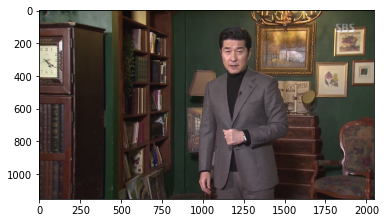

In [210]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image_05.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## DeepLab V3+ 세그멘테이션 모델로 사람 분리하기
* 여러 segmentation model 중 성능이 상위권에 많이 포진되어 있는 model
* semantic segmentaion을 잘 해결하기 위한 방법으로 atrous convolution을 적극적으로 활용할 것을 제안
* 최근 발표된 V3+에서는 separable convolution과 atrous convolution을 결합한 atrous separable convolution의 활용을 제안
* Atrous convolution을 활용하면 파라미터 수를 늘리지 않으면서도 receptive field를 크게 키울 수 있기 때문에 DeepLab series에서는 이를 적극적으로 활용하려 노력
* 참고 링크 : [DeepLab V3+: Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/)

In [211]:
# PixelLib에서 제공해주는 모델 다운로드

# 저장할 파일 이름을 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f1d20fcea90>)

In [212]:
# PixelLib으로 사용할 세그멘테이션 모델을 생성

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [213]:
# 모델에 이미지 입력

segvalues, output = model.segmentAsPascalvoc(img_path)

In [214]:
# PASCAL VOC 데이터의 라벨 종류 확인
# background를 제외한 20개의 클래스가 존재 ex) 20의 의미는 'tv'
# 이 중에서 사람(person) 라벨, 15를 가진 영역을 이미지에서 검출

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

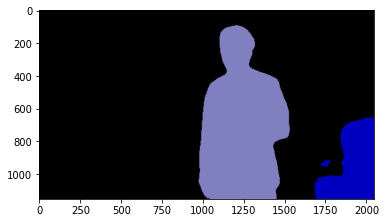

In [215]:
# 모델에서 나온 출력값 확인

plt.imshow(output)
plt.show()

output에서는 세그멘테이션 결과가 각각 다른 색상으로 담겨 있는 것을 확인할 수 있다.

In [216]:
segvalues

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [217]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


segvalues에는 class_ids와 masks가 존재하며, class_ids를 통해 어떤 물체가 담겨 있는지 파악할 수 있다.

In [218]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib으로 사용된 색상을 확인할 수 있다. 아래의 코드를 통해 사람을 나타내는 15번째 색상을 확인한다.

In [219]:
colormap[15]

array([192, 128, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾아낼 수 있다. 여기서 주의할 부분은 output 이미지가 BGR 순서로, colormap은 RGB 순서로 채널 배치가 되어 있기 때문에 아래의 코드를 통해 색상값의 순서를 변경하여야 한다.

In [220]:
seg_color = (128,128,192)

(1152, 2048)


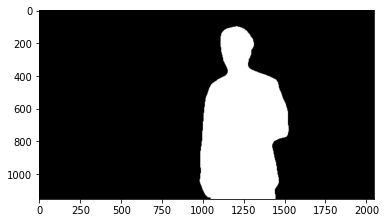

In [221]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

seg_color로만 이루어진 마스크를 생성했을 때, 3채널을 가졌던 원본과는 다르게 채널 정보가 사라진 것을 알 수 있다. 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었다. 아래 코드를 통해 세그멘테이션이 잘 되었는지 확인 해 보도록 한다.

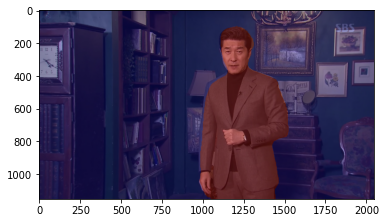

In [222]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## blur() 함수를 이용하여 배경 흐리게 하기

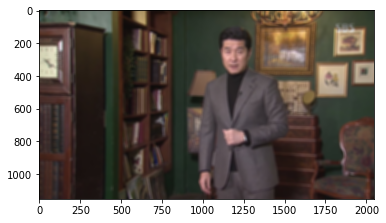

In [223]:
# 괄호 안의 숫자는 blurring kernel size를 뜻합니다

img_orig_blur = cv2.blur(img_orig, (20,20))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

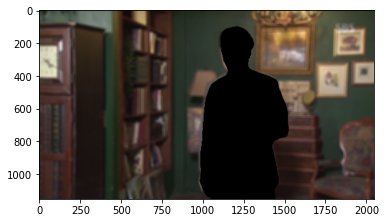

In [224]:
# 흐려진 이미지에서 세그멘테이션 마스트를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전된다. 원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 되는 것이다. 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있다.

## 흐린 배경과 원본 영상 합성
np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용하여 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용한다.

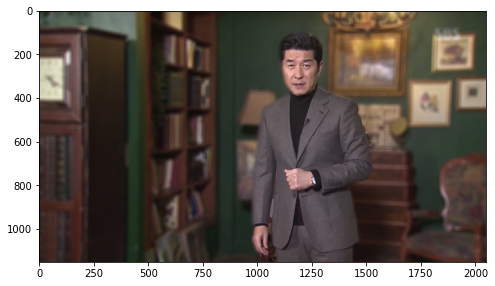

In [225]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.figure(figsize=(8,8)) # 크게 보기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

이로써 인물에 포커스를 맞춘 사진이 완성되었다. 그러나 인물과 배경의 경계가 다소 흐리게 설정된 것을 이미지 왼쪽 부분에서 알 수 있다. 다음으로 다양한 사진을 이용한 인물 포커싱 사진도 만들어 보도록 하겠다.

* * *

## 오래된 저화질 사진의 경우

(1629, 2313, 3)


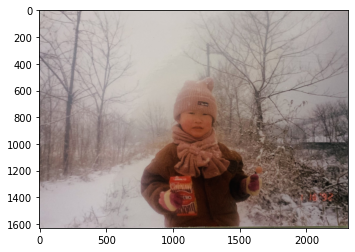

In [226]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image_06.png'  
img_orig2 = cv2.imread(img_path2) 

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

In [227]:
# PixelLib으로 사용할 세그멘테이션 모델을 생성

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [228]:
# 모델에 이미지 입력

segvalues2, output2 = model.segmentAsPascalvoc(img_path2)

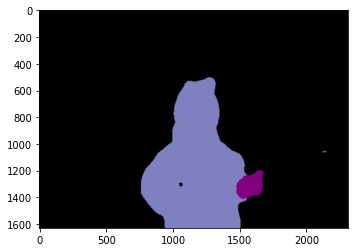

In [229]:
# 모델에서 나온 출력값 확인

plt.imshow(output2)
plt.show()

In [230]:
segvalues2

{'class_ids': array([ 0,  5,  7, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [231]:
for class_id in segvalues2['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
car
person


사용한 이미지는 아이가 사탕과 과자 박스를 들고 있는 사진이나, 워낙 사진이 오래된 관계로 이미지 내의 물체가 제대로 인식이 되어 있지 않은 것이 확인된다.

In [232]:
colormap2 = np.zeros((256, 3), dtype = int)
ind2 = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap2[:, channel] |= ((ind2 >> channel) & 1) << shift
    ind2 >>= 3

colormap2[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [235]:
colormap2[15]

array([192, 128, 128])

In [236]:
seg_color2 = (128,128,192)

(1629, 2313)


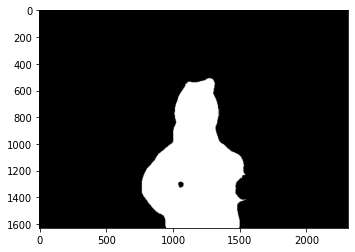

In [238]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map2 = np.all(output2==seg_color2, axis=-1)
print(seg_map2.shape)
plt.imshow(seg_map2, cmap='gray')
plt.show()

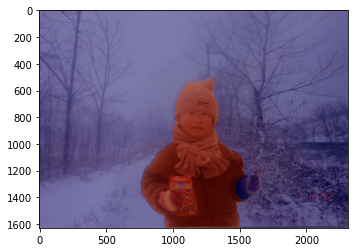

In [240]:
img_show2 = img_orig2.copy()
img_mask2 = seg_map2.astype(np.uint8) * 255
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

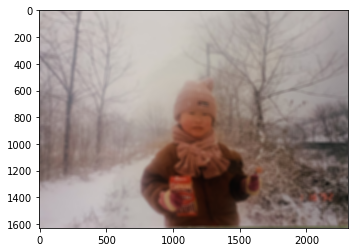

In [241]:
img_orig_blur2 = cv2.blur(img_orig2, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

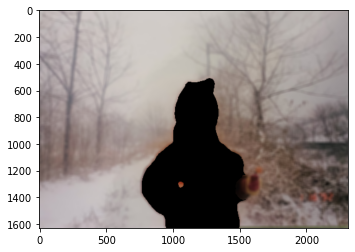

In [242]:
img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

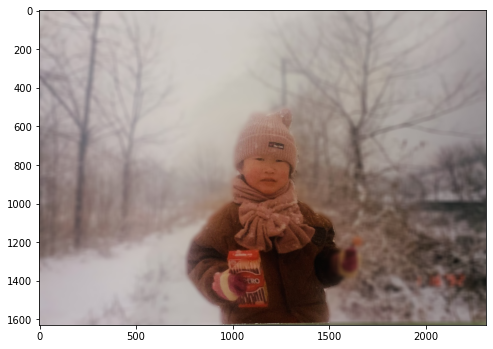

In [243]:
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)
plt.figure(figsize=(8,8)) # 크게 보기
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

오래된 저화질 사진으로 시도했을 때는 인물과 배경의 경계가 명확하게 설정되지 않는 문제점을 확인할 수 있는데, 사진 오른쪽의 팔 부분이 흐리게 처리된 것이 보인다.

* * *

## 인물 사진이 배경으로 설정되었을 경우

(1041, 650, 3)


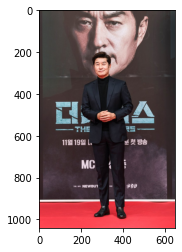

In [244]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image_02.png'  
img_orig3 = cv2.imread(img_path3) 

print(img_orig3.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

In [245]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [246]:
segvalues3, output3 = model.segmentAsPascalvoc(img_path3)

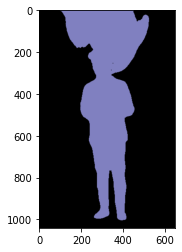

In [247]:
plt.imshow(output3)
plt.show()

In [248]:
segvalues3

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [249]:
for class_id in segvalues3['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [250]:
colormap3 = np.zeros((256, 3), dtype = int)
ind3 = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap3[:, channel] |= ((ind3 >> channel) & 1) << shift
    ind3 >>= 3

colormap3[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [251]:
colormap3[15]

array([192, 128, 128])

In [252]:
seg_color3 = (128,128,192)

(1041, 650)


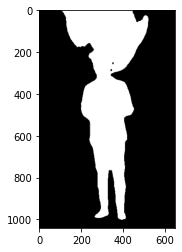

In [254]:
seg_map3 = np.all(output3==seg_color3, axis=-1)
print(seg_map3.shape)
plt.imshow(seg_map3, cmap='gray')
plt.show()

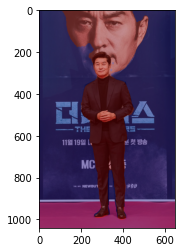

In [255]:
img_show3 = img_orig3.copy()
img_mask3 = seg_map3.astype(np.uint8) * 255
color_mask3 = cv2.applyColorMap(img_mask3, cv2.COLORMAP_JET)
img_show3 = cv2.addWeighted(img_show3, 0.6, color_mask3, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.show()

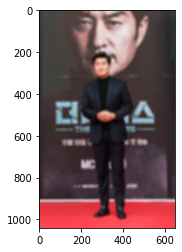

In [256]:
img_orig_blur3 = cv2.blur(img_orig3, (15,15))  
plt.imshow(cv2.cvtColor(img_orig_blur3, cv2.COLOR_BGR2RGB))
plt.show()

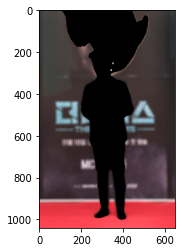

In [257]:
img_mask_color3 = cv2.cvtColor(img_mask3, cv2.COLOR_GRAY2BGR)
img_bg_mask3 = cv2.bitwise_not(img_mask_color3)
img_bg_blur3 = cv2.bitwise_and(img_orig_blur3, img_bg_mask3)
plt.imshow(cv2.cvtColor(img_bg_blur3, cv2.COLOR_BGR2RGB))
plt.show()

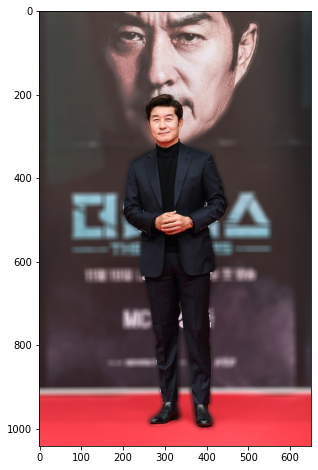

In [258]:
img_concat3 = np.where(img_mask_color3==255, img_orig3, img_bg_blur3)
plt.figure(figsize=(8,8)) # 크게 보기
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

인물의 얼굴 사진을 배경으로 한 인물 사진에 이 모델을 적용했을 경우, 인물과 함께 배경의 인물 사진 부분도 같이 인물로 인식된다는 문제가 있다.

* * *

## 인물이 물체에 앉아 있는 (오래된) 사진의 경우

(2465, 3539, 3)


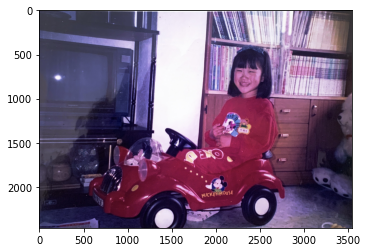

In [259]:
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image_11.png'  
img_orig4 = cv2.imread(img_path4) 

print(img_orig4.shape)
plt.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))
plt.show()

In [260]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [261]:
segvalues4, output4 = model.segmentAsPascalvoc(img_path4)

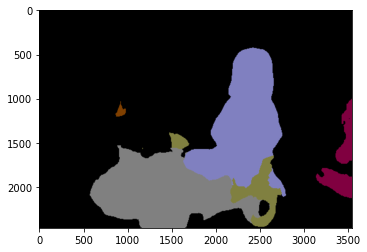

In [262]:
plt.imshow(output4)
plt.show()

In [263]:
segvalues4

{'class_ids': array([ 0,  7, 12, 14, 15, 20]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [264]:
for class_id in segvalues4['class_ids']:
    print(LABEL_NAMES[class_id])

background
car
dog
motorbike
person
tv


In [265]:
colormap4 = np.zeros((256, 3), dtype = int)
ind4 = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap4[:, channel] |= ((ind4 >> channel) & 1) << shift
    ind4 >>= 3

colormap4[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [266]:
colormap4[15]

array([192, 128, 128])

In [267]:
seg_color4 = (128,128,192)

(2465, 3539)


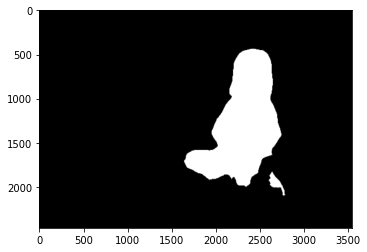

In [268]:
seg_map4 = np.all(output4==seg_color4, axis=-1)
print(seg_map4.shape)
plt.imshow(seg_map4, cmap='gray')
plt.show()

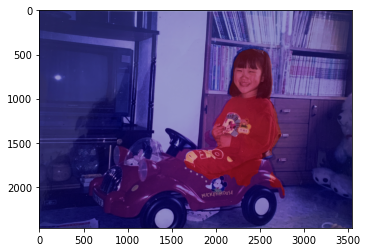

In [269]:
img_show4 = img_orig4.copy()
img_mask4 = seg_map4.astype(np.uint8) * 255
color_mask4 = cv2.applyColorMap(img_mask4, cv2.COLORMAP_JET)
img_show4 = cv2.addWeighted(img_show4, 0.6, color_mask4, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

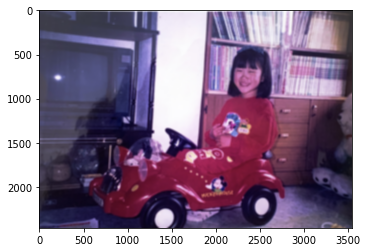

In [270]:
img_orig_blur4 = cv2.blur(img_orig4, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur4, cv2.COLOR_BGR2RGB))
plt.show()

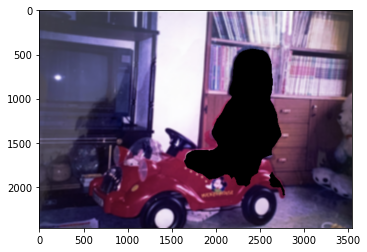

In [271]:
img_mask_color4 = cv2.cvtColor(img_mask4, cv2.COLOR_GRAY2BGR)
img_bg_mask4 = cv2.bitwise_not(img_mask_color4)
img_bg_blur4 = cv2.bitwise_and(img_orig_blur4, img_bg_mask4)
plt.imshow(cv2.cvtColor(img_bg_blur4, cv2.COLOR_BGR2RGB))
plt.show()

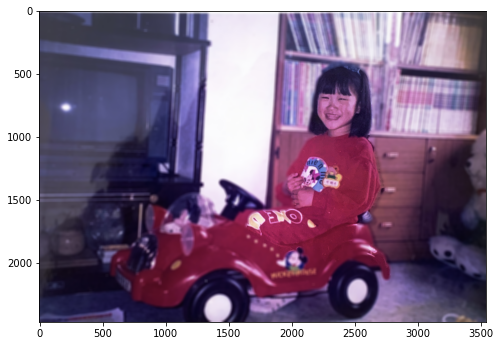

In [272]:
img_concat4 = np.where(img_mask_color4==255, img_orig4, img_bg_blur4)
plt.figure(figsize=(8,8)) # 크게 보기
plt.imshow(cv2.cvtColor(img_concat4, cv2.COLOR_BGR2RGB))
plt.show()

해당 이미지의 경우 인물이 입은 옷과 앉아있는 물체의 색상이 유사한데다 오래된 사진이기 때문에 분류 단계에서는 정확하지 않았으나, 최종 결과물에는 큰 영향이 없는 것으로 보인다.

* * *

## 고양이 이미지도 제대로 인식할 수 있을까?

(1152, 2048, 3)


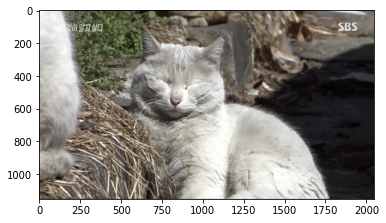

In [273]:
img_path_cat = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat04.png'  
img_orig_cat = cv2.imread(img_path_cat) 

print(img_orig_cat.shape)
plt.imshow(cv2.cvtColor(img_orig_cat, cv2.COLOR_BGR2RGB))
plt.show()

In [274]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [275]:
segvalues_cat, output_cat = model.segmentAsPascalvoc(img_path_cat)

In [276]:
# PASCAL VOC 데이터의 라벨 종류 확인
# background를 제외한 20개의 클래스가 존재 ex) 20의 의미는 'tv'
# 이 중에서 고양이(cat) 라벨, 8을 가진 영역을 이미지에서 검출

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

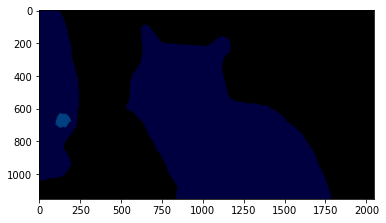

In [277]:
plt.imshow(output_cat)
plt.show()

In [278]:
segvalues_cat

{'class_ids': array([ 0,  8, 17]),
 'masks': array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [279]:
for class_id in segvalues_cat['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
sheep


In [281]:
colormap_cat = np.zeros((256, 3), dtype = int)
ind_cat = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap_cat[:, channel] |= ((ind_cat >> channel) & 1) << shift
    ind_cat >>= 3

colormap_cat[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [282]:
colormap_cat[8]

array([64,  0,  0])

In [283]:
seg_color_cat = (0,0,64)

(1152, 2048)


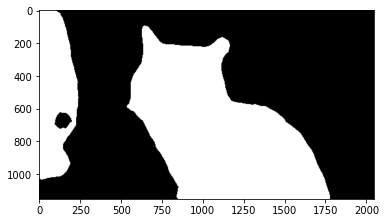

In [284]:
seg_map_cat = np.all(output_cat==seg_color_cat, axis=-1)
print(seg_map_cat.shape)
plt.imshow(seg_map_cat, cmap='gray')
plt.show()

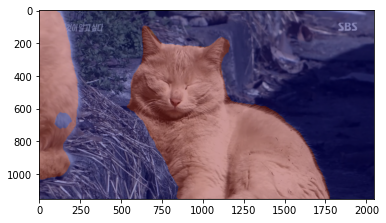

In [285]:
img_show_cat = img_orig_cat.copy()
img_mask_cat = seg_map_cat.astype(np.uint8) * 255
color_mask_cat = cv2.applyColorMap(img_mask_cat, cv2.COLORMAP_JET)
img_show_cat = cv2.addWeighted(img_show_cat, 0.6, color_mask_cat, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show_cat, cv2.COLOR_BGR2RGB))
plt.show()

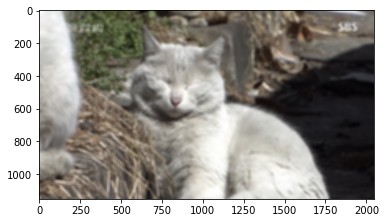

In [286]:
img_orig_blur_cat = cv2.blur(img_orig_cat, (20,20))  
plt.imshow(cv2.cvtColor(img_orig_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

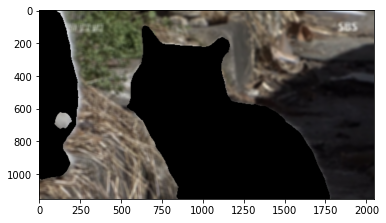

In [287]:
img_mask_color_cat = cv2.cvtColor(img_mask_cat, cv2.COLOR_GRAY2BGR)
img_bg_mask_cat = cv2.bitwise_not(img_mask_color_cat)
img_bg_blur_cat = cv2.bitwise_and(img_orig_blur_cat, img_bg_mask_cat)
plt.imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

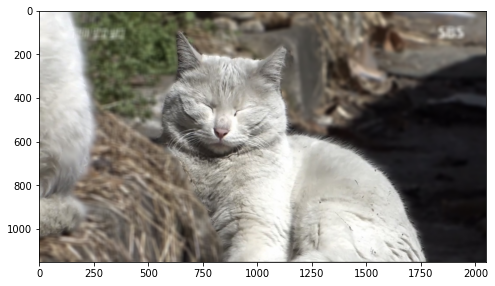

In [288]:
img_concat_cat = np.where(img_mask_color_cat==255, img_orig_cat, img_bg_blur_cat)
plt.figure(figsize=(8,8)) # 크게 보기
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.show()

해당 이미지에 있는 두 마리의 고양이 중에서 한 마리는 일부분만 촬영되었음에도 불구하고 모델이 확실하게 인식하였음을 알 수 있다. 그러나 왼쪽 고양이 이미지의 일부분은 모델이 배경으로 인식한다.

* * *

## 크로마키 배경 합성하기
이 과정에서는 단순히 배경을 흐리게 하는 것이 아닌, 물체와 다른 배경을 합성하는 작업을 시도할 것이다. np.where에 대한 원리가 아직은 익숙하지 않아 노드를 보면서도 어느 부분의 코드를 변경해서 적용해야 할 지 이해하기 어려운 부분이 있어 같은 교육생인 손지수님의 도움을 받아 진행하였다.

(2415, 3359, 3)


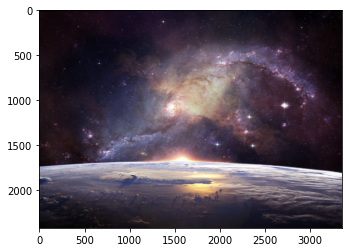

In [295]:
img_path_bg = os.getenv('HOME')+'/aiffel/human_segmentation/images/space02.png'  
img_orig_bg = cv2.imread(img_path_bg) 

print(img_orig_bg.shape)
resize_bg = cv2.resize(img_orig_bg,(1152,2048), interpolation=cv2.INTER_AREA)
# 배경을 이미지에 맞춰야 하기 때문에, 배경 이미지 크기의 리사이징이 필요
plt.imshow(cv2.cvtColor(img_orig_bg, cv2.COLOR_BGR2RGB))
plt.show()

In [296]:
img_concat_cat = np.where(img_mask_color_cat==255, img_orig_cat, img_orig_bg)

plt.figure(figsize=(8,8)) # 크게 보기
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.show()

ValueError: operands could not be broadcast together with shapes (1152,2048,3) (1152,2048,3) (2415,3359,3) 

직전에 작업했던 고양이 이미지를 우주 이미지와 합성하려고 시도하였으나, 위와 같이 ValueError가 발생되었다. 배경 이미지의 크기를 고양이 이미지의 크기와 맞추었음에도 불구하고 이러한 오류가 발생했는데, 이는 이미지가 가지는 차원의 크기가 다르기 때문에 발생한 오류로 추측된다.
* 참고 링크 : [[Python Numpy] 다른 차원의 배열 간 산술연산 시 Broadcasting](https://rfriend.tistory.com/287)

In [297]:
img_concat_cat = np.where(img_mask_color_cat==255, img_orig_cat, resize_bg)

plt.figure(figsize=(8,8)) # 크게 보기
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.show()

ValueError: operands could not be broadcast together with shapes (1152,2048,3) (1152,2048,3) (2048,1152,3) 

배경에 해당하는 변수명을 resize_bg로 변경하였음에도 동일한 오류가 발생하는 것을 확인할 수 있다. 새로운 고양이 이미지를 이용하여 합성을 시도 해 보도록 하겠다.

(2560, 4096, 3)


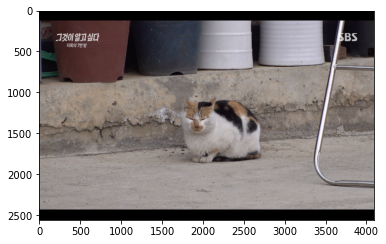

In [300]:
img_path_cat2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat02.png'  
img_orig_cat2 = cv2.imread(img_path_cat2) 

print(img_orig_cat2.shape)
plt.imshow(cv2.cvtColor(img_orig_cat2, cv2.COLOR_BGR2RGB))
plt.show()

In [301]:
segvalues_cat2, output_cat2 = model.segmentAsPascalvoc(img_path_cat2)

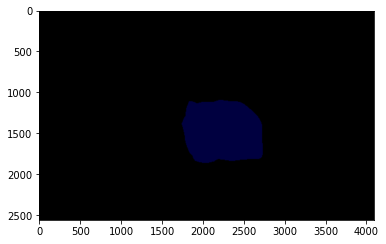

In [302]:
plt.imshow(output_cat2)
plt.show()

In [303]:
segvalues_cat2

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [304]:
for class_id in segvalues_cat2['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [305]:
colormap_cat2 = np.zeros((256, 3), dtype = int)
ind_cat2 = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap_cat2[:, channel] |= ((ind_cat2 >> channel) & 1) << shift
    ind_cat2 >>= 3

colormap_cat2[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [306]:
colormap_cat2[8]

array([64,  0,  0])

In [307]:
seg_color_cat2 = (0,0,64)

(2560, 4096)


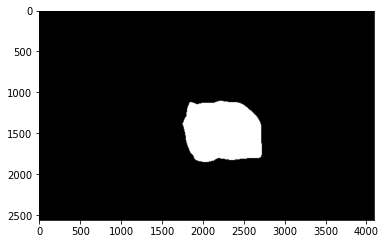

In [308]:
seg_map_cat2 = np.all(output_cat2==seg_color_cat2, axis=-1)
print(seg_map_cat2.shape)
plt.imshow(seg_map_cat2, cmap='gray')
plt.show()

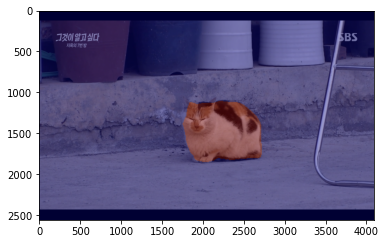

In [309]:
img_show_cat2 = img_orig_cat2.copy()
img_mask_cat2 = seg_map_cat2.astype(np.uint8) * 255
color_mask_cat2 = cv2.applyColorMap(img_mask_cat2, cv2.COLORMAP_JET)
img_show_cat2 = cv2.addWeighted(img_show_cat2, 0.6, color_mask_cat2, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show_cat2, cv2.COLOR_BGR2RGB))
plt.show()

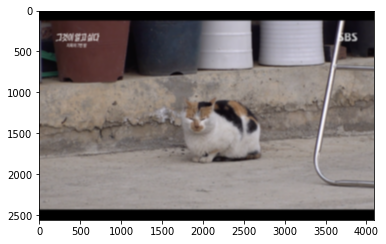

In [311]:
img_orig_blur_cat2 = cv2.blur(img_orig_cat2, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur_cat2, cv2.COLOR_BGR2RGB))
plt.show()

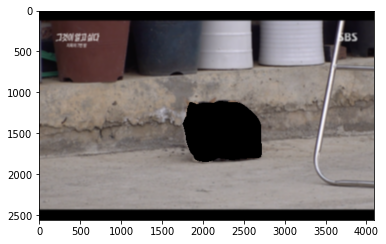

In [313]:
img_mask_color_cat2 = cv2.cvtColor(img_mask_cat2, cv2.COLOR_GRAY2BGR)
img_bg_mask_cat2 = cv2.bitwise_not(img_mask_color_cat2)
img_bg_blur_cat2 = cv2.bitwise_and(img_orig_blur_cat2, img_bg_mask_cat2)
plt.imshow(cv2.cvtColor(img_bg_blur_cat2, cv2.COLOR_BGR2RGB))
plt.show()

배경의 이미지를 새로운 고양이 이미지에 맞게 다시 조정하도록 한다.

(2415, 3359, 3)


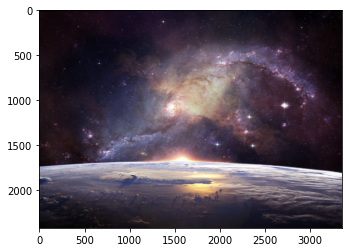

In [316]:
img_path_bg2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/space02.png'  
img_orig_bg2 = cv2.imread(img_path_bg2) 

print(img_orig_bg2.shape)
resize_bg2 = cv2.resize(img_orig_bg2,(2560,4096), interpolation=cv2.INTER_AREA)
# 배경을 이미지에 맞춰야 하기 때문에, 배경 이미지 크기의 리사이징이 필요
plt.imshow(cv2.cvtColor(img_orig_bg2, cv2.COLOR_BGR2RGB))
plt.show()

In [333]:
img_concat_cat2 = np.where(img_mask_color_cat2==255, img_orig_cat2, resize_bg2)

plt.figure(figsize=(8,8)) # 크게 보기
plt.imshow(cv2.cvtColor(img_concat_cat2, cv2.COLOR_BGR2RGB))
plt.show()

ValueError: operands could not be broadcast together with shapes (2560,4096,3) (2560,4096,3) (4096,2560,3) 

새로운 이미지를 이용하였음에도 아까와 같은 오류가 발생하는 것을 확인할 수 있다. 그렇다면 포토샵을 통해 미리 이미지를 같은 사이즈로 수정할 경우에는 배경 합성이 가능한지 확인 해 보자.

(1404, 2500, 3)


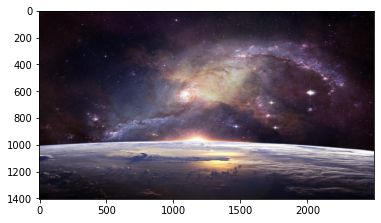

In [318]:
img_path_bg3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/space02_re.png'  
img_orig_bg3 = cv2.imread(img_path_bg3) 

print(img_orig_bg3.shape)
plt.imshow(cv2.cvtColor(img_orig_bg3, cv2.COLOR_BGR2RGB))
plt.show()

(1404, 2500, 3)


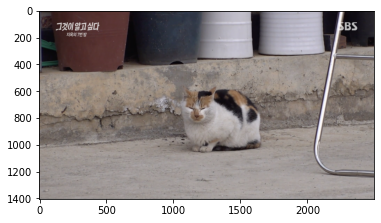

In [319]:
img_path_cat3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat02_re.png'  
img_orig_cat3 = cv2.imread(img_path_cat3) 

print(img_orig_cat3.shape)
plt.imshow(cv2.cvtColor(img_orig_cat3, cv2.COLOR_BGR2RGB))
plt.show()

In [320]:
segvalues_cat3, output_cat3 = model.segmentAsPascalvoc(img_path_cat3)

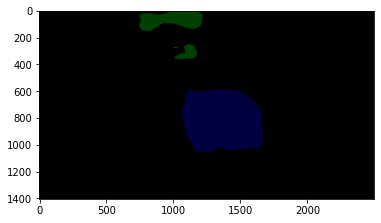

In [321]:
plt.imshow(output_cat3)
plt.show()

In [322]:
segvalues_cat3

{'class_ids': array([ 0,  8, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [323]:
for class_id in segvalues_cat3['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
pottedplant


In [324]:
colormap_cat3 = np.zeros((256, 3), dtype = int)
ind_cat3 = np.arange(256, dtype = int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap_cat3[:, channel] |= ((ind_cat3 >> channel) & 1) << shift
    ind_cat3 >>= 3

colormap_cat3[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [325]:
colormap_cat3[8]

array([64,  0,  0])

In [326]:
seg_color_cat3 = (0,0,64)

(1404, 2500)


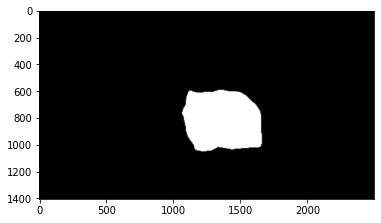

In [328]:
seg_map_cat3 = np.all(output_cat3 == seg_color_cat3, axis=-1)
print(seg_map_cat3.shape)
plt.imshow(seg_map_cat3, cmap = 'gray')
plt.show()

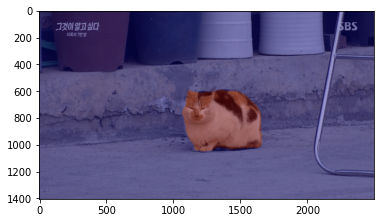

In [329]:
img_show_cat3 = img_orig_cat3.copy()
img_mask_cat3 = seg_map_cat3.astype(np.uint8) * 255
color_mask_cat3 = cv2.applyColorMap(img_mask_cat3, cv2.COLORMAP_JET)
img_show_cat3 = cv2.addWeighted(img_show_cat3, 0.6, color_mask_cat3, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show_cat3, cv2.COLOR_BGR2RGB))
plt.show()

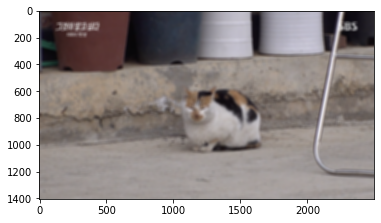

In [330]:
img_orig_blur_cat3 = cv2.blur(img_orig_cat3, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur_cat3, cv2.COLOR_BGR2RGB))
plt.show()

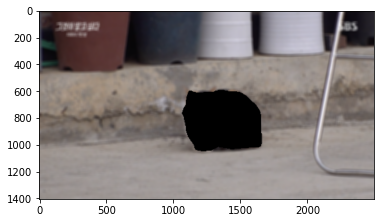

In [331]:
img_mask_color_cat3 = cv2.cvtColor(img_mask_cat3, cv2.COLOR_GRAY2BGR)
img_bg_mask_cat3 = cv2.bitwise_not(img_mask_color_cat3)
img_bg_blur_cat3 = cv2.bitwise_and(img_orig_blur_cat3, img_bg_mask_cat3)
plt.imshow(cv2.cvtColor(img_bg_blur_cat3, cv2.COLOR_BGR2RGB))
plt.show()

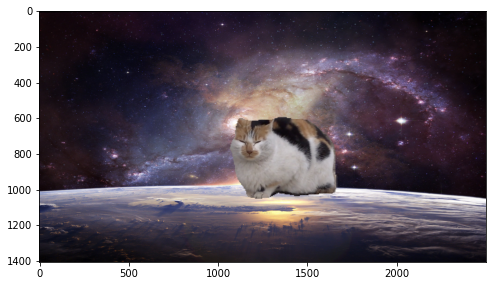

In [332]:
img_concat_cat3 = np.where(img_mask_color_cat3==255, img_orig_cat3, img_orig_bg3)

plt.figure(figsize=(8,8)) # 크게 보기
plt.imshow(cv2.cvtColor(img_concat_cat3, cv2.COLOR_BGR2RGB))
plt.show()

우주를 배경으로 한 고양이 이미지가 완성되었다.

* * *

## 회고
* 여러 이미지들을 분류하는 과정에서 발생했던 문제점들은 다음과 같다 : 
  1. 배경으로 사용된 인물 사진과 대상이 되는 인물 사진이 분류되지 못하는 문제
  2. 너무 오래되어 화질이 떨어지는 사진의 경우, 물체를 제대로 인식하지 못하는 문제
  3. 인물이 입은 옷과 가까이 있는 물체의 색상이 유사한 경우, 인물을 제대로 인식하지 못하는 문제
  4. 인물과 배경의 경계선 일부가 흐리게 보이는 문제
* 현재로써는 이러한 문제들을 사전에 방지하기 위해서는 배경과의 경계가 어느 정도 명확한 인물 사진을 찾는 것이 중요하다고 판단되었다.
* 크로마키 배경 합성 과제를 수행했을 때 배경과 대상의 이미지 크기가 달라 배열을 broadcast하지 못하는 오류는 코드 수정으로도 한계를 느껴 결국 포토샵으로 이미지 크기를 똑같이 수정하는 방식으로 진행하였지만, 만약 이러한 작업을 여러 번 수행할 시에 현실적으로 포토샵을 이용한 이미지 크기 조절이 불가능하다는 것을 고려하면 어떻게 효율적으로 문제를 해결할 수 있을지에 대한 탐색이 필요하다고 느꼈다.